Links

https://homes.cs.washington.edu/~thickstn/spectrograms.html

https://towardsdatascience.com/audio-classification-using-fastai-and-on-the-fly-frequency-transforms-4dbe1b540f89

https://dkopczyk.quantee.co.uk/speech-nn/

In [45]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import IPython.display as ipd
from scipy.signal import get_window, spectrogram, stft

In [10]:
filename = 'stavros/talkwithothernoschedule_trimmed.wav'

In [16]:
ipd.Audio(filename) # load a local WAV file

In [11]:
clip, sample_rate = librosa.load(filename, sr=None)
clip = clip[:132300] # first three seconds of file

timesteps = np.arange(len(clip)) / sample_rate  # in seconds

In [22]:
print(f'Sample rate: {sample_rate}, length: {len(clip)}, seconds: {len(clip)/sample_rate:.2f}')

Sample rate: 22050, length: 83968, seconds: 3.81


In [35]:
clip[1:10]

array([0.000205  , 0.00021123, 0.00020274, 0.00016906, 0.00018139,
       0.00019765, 0.00019269, 0.00019614, 0.00018045], dtype=float32)

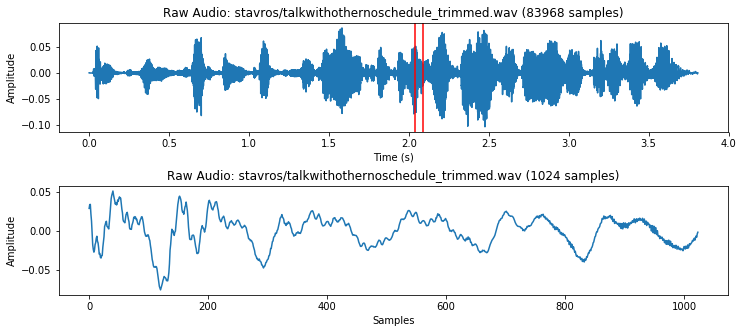

In [14]:
fig, ax = plt.subplots(2, figsize=(12, 5))
fig.subplots_adjust(hspace=0.5)

# plot the entire clip 
ax[0].plot(timesteps, clip)
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Amplitude')
ax[0].set_title('Raw Audio: {} ({} samples)'.format(filename, len(clip)))


n_fft = 1024 # frame length 
start = 45000 # start at a part of the sound thats not silence.. 
x = clip[start:start+n_fft]

# mark location of frame in the entire signal
ax[0].axvline(start/sample_rate, c='r') 
ax[0].axvline((start+n_fft)/sample_rate, c='r')

# plot N samples 
ax[1].plot(x)
ax[1].set_xlabel('Samples')
ax[1].set_ylabel('Amplitude')
ax[1].set_title('Raw Audio: {} ({} samples)'.format(filename, len(x)));

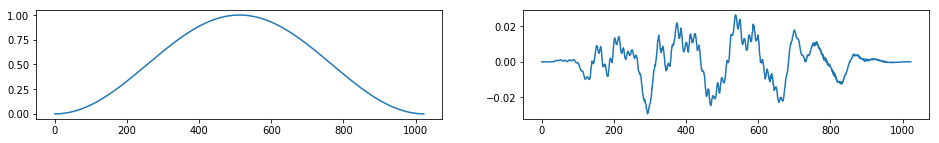

In [25]:
window = get_window('hann', n_fft)
wx = x * window

fig, ax = plt.subplots(1, 2, figsize=(16, 2))
ax[0].plot(window)
ax[1].plot(wx);

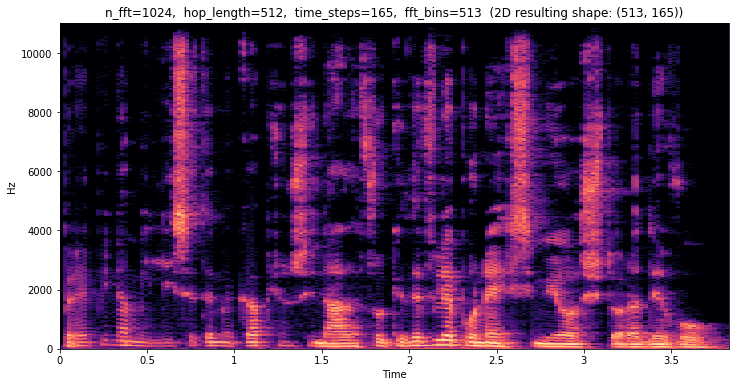

In [28]:
hop_length = 512
stft = librosa.stft(clip, n_fft=n_fft, hop_length=hop_length)
stft_magnitude, stft_phase = librosa.magphase(stft)
stft_magnitude_db = librosa.amplitude_to_db(stft_magnitude, ref=np.max)

plt.figure(figsize=(12, 6))
librosa.display.specshow(stft_magnitude_db, x_axis='time', y_axis='linear', 
                         sr=sample_rate, hop_length=hop_length)

title = 'n_fft={},  hop_length={},  time_steps={},  fft_bins={}  (2D resulting shape: {})'
plt.title(title.format(n_fft, hop_length, 
                       stft_magnitude_db.shape[1], 
                       stft_magnitude_db.shape[0], 
                       stft_magnitude_db.shape));

C:\ProgramData\Anaconda3\envs\pytorch\lib\site-packages\librosa\filters.py:222: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '


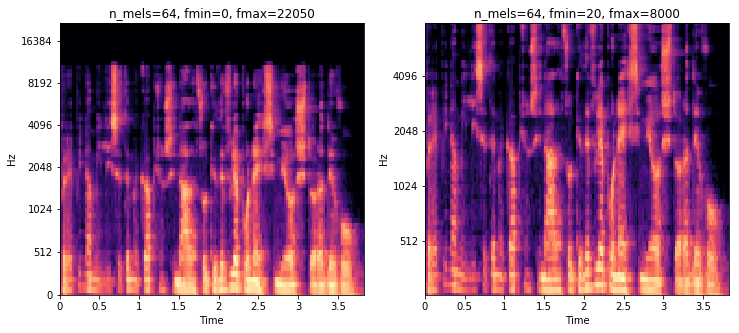

In [29]:
# number of mel frequency bands 
n_mels = 64

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

fmin = 0            
fmax = 22050 # sample_rate/2
mel_spec = librosa.feature.melspectrogram(clip, n_fft=n_fft, hop_length=hop_length,
                                          n_mels=n_mels, sr=sample_rate, power=1.0,
                                          fmin=fmin, fmax=fmax)
mel_spec_db = librosa.amplitude_to_db(mel_spec, ref=np.max)
librosa.display.specshow(mel_spec_db, x_axis='time',  y_axis='mel', 
                         sr=sample_rate, hop_length=hop_length, 
                         fmin=fmin, fmax=fmax, ax=ax[0])
ax[0].set_title('n_mels=64, fmin=0, fmax=22050')

fmin = 20           
fmax = 8000
mel_spec = librosa.feature.melspectrogram(clip, n_fft=n_fft, hop_length=hop_length,
                                          n_mels=n_mels, sr=sample_rate, power=1.0, 
                                          fmin=fmin, fmax=fmax)
mel_spec_db = librosa.amplitude_to_db(mel_spec, ref=np.max)
librosa.display.specshow(mel_spec_db, x_axis='time',  y_axis='mel', 
                         sr=sample_rate, hop_length=hop_length, 
                         fmin=fmin, fmax=fmax, ax=ax[1])
ax[1].set_title('n_mels=64, fmin=20, fmax=8000')

plt.show()

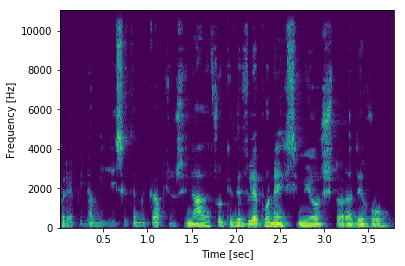

In [67]:
freqs, times, spec = spectrogram(clip, sample_rate)

amp = np.log(np.abs(spec)+1e-10)

plt.pcolormesh(times, freqs, amp)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [71]:
times[:10], np.log(times[:10])

(array([0.00580499, 0.01596372, 0.02612245, 0.03628118, 0.04643991,
        0.05659864, 0.06675737, 0.0769161 , 0.08707483, 0.09723356]),
 array([-5.14903762, -4.13743671, -3.64496022, -3.31645615, -3.06959608,
        -2.87177033, -2.70669058, -2.56504006, -2.44098742, -2.33063936]))

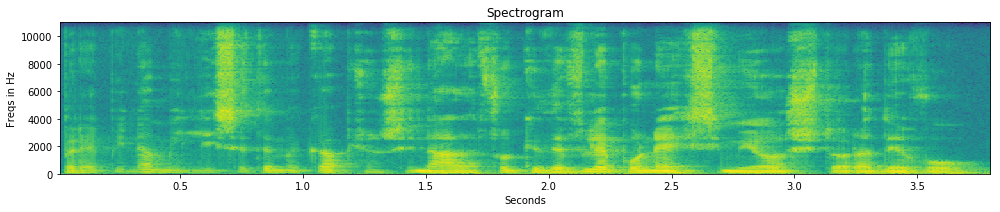

In [52]:
def log_spectrogram(wav):
    freqs, times, spec = stft(wav, sample_rate, nperseg = 400, noverlap = 240, nfft = 512, 
                              padded = False, boundary = None)
    # Log spectrogram
    amp = np.log(np.abs(spec)+1e-10)
    
    return freqs, times, amp

fig = plt.figure(figsize=(14, 8))

freqs, times, amp = log_spectrogram(clip)
    
ax = fig.add_subplot(3,1,1)
ax.imshow(amp, aspect='auto', origin='lower', 
               extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax.set_title('Spectrogram')
ax.set_ylabel('Freqs in Hz')
ax.set_xlabel('Seconds')

fig.tight_layout()

In [54]:
freqs.shape, times.shape, amp.shape

((257,), (523,), (257, 523))

In [62]:
freqs[:10], freqs[-10:]

(array([  0.        ,  43.06640625,  86.1328125 , 129.19921875,
        172.265625  , 215.33203125, 258.3984375 , 301.46484375,
        344.53125   , 387.59765625]),
 array([10637.40234375, 10680.46875   , 10723.53515625, 10766.6015625 ,
        10809.66796875, 10852.734375  , 10895.80078125, 10938.8671875 ,
        10981.93359375, 11025.        ]))

In [60]:
times[:10], times[-10:]

(array([0.00907029, 0.01632653, 0.02358277, 0.030839  , 0.03809524,
        0.04535147, 0.05260771, 0.05986395, 0.06712018, 0.07437642]),
 array([3.73151927, 3.73877551, 3.74603175, 3.75328798, 3.76054422,
        3.76780045, 3.77505669, 3.78231293, 3.78956916, 3.7968254 ]))

In [66]:
amp[:3,:3]

array([[ -9.297342 ,  -8.920652 ,  -9.714706 ],
       [ -9.622279 ,  -9.336665 ,  -8.283218 ],
       [-11.091541 , -11.21325  ,  -8.0860615]], dtype=float32)

1.0986122886681098